 NOTE:
 Currently non-working, because tfp_fixed_step.py needs updating. Probably a good copy on the HP somewhere

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import InterpolatorMask, InterpolatorMaskArgs, InterpolatorMask2

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *

No pretty printing stuff (probably because no Pandas)


## Qutip style problem definition

In [4]:

#problem definition
K1, K2  = q.basis(2,0), q.basis(2,1), 
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)
H0 = 2*pi*K2*K2.dag()
c_opL = [sqrt(.1)*q.sigmap()]

H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-2,2,100)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )

drv_step_size = 0.01
tDrv = np.linspace(0,2.0,200)+drv_step_size/2 #Times where the value of the driving field is defined ("control points")
driving =  np.exp(1j*2*np.pi* tDrv)
driving_interpolator_r = InterpolatorMask2(tDrv, driving.real) #These will interpolate between the supplied control points
driving_interpolator_i = InterpolatorMask2(tDrv, driving.imag)
ode_s.set_driving({ES_r:driving_interpolator_r, ES_i:driving_interpolator_i}) # map the symbols ES_r and ES_i to the driving functions
ode_s.setup(bForceStateDimensions=True)

#Now run
step_size= 1e-2
tSteps = np.linspace(0,2.0, 100) # Times when values will be returned
%time res1= ode_s.integrate(tSteps, step_size=step_size)
print("\n")
print("after JIT compiling, subsequent runs are much faster:")
%time res2= ode_s.integrate(tSteps, step_size=step_size)
print('\n')
print("To avoid recompilation, change the driving fields using the methods on the interpolation oobjects (uses tensorflow variables)")
driving =  np.exp(2j*2*np.pi* tDrv)
driving_interpolator_r.set_y(driving.real)
driving_interpolator_i.set_y(driving.imag)
%time res3= ode_s.integrate(tSteps, step_size=step_size)

#Plotting
plot(res1[:,1].numpy().mean(axis=-1))
plot(res2[:,1].numpy().mean(axis=-1))
plot(res3[:,1].numpy().mean(axis=-1))
legend(np.arange(3))
title('excited state pop')


Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E_r, E_i], 'state_dep_syms': [Delta]})
state dependent functions should have signature <itertools.chain object at 0x7fec3ec29d60>


NameError: in user code:

    /home/morgan/dev_local/spylind/spylind/spyIVP.py:768 integrate_tf  *
        results_obj =tfp.math.ode.FixedStep(**kwargs).solve(self.d_dt_fast.__call__, tSteps[0], yInit, solution_times=tSteps)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow_probability/python/math/ode/base.py:475 solve  **
        return gradient_helper(*(flat_initial_state + flat_constants))
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:261 __call__
        return self._d(self._f, a, k)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:217 decorated
        return _graph_mode_decorator(wrapped, args, kwargs)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:330 _graph_mode_decorator
        result, grad_fn = f(*args)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow_probability/python/math/ode/base.py:231 gradient_helper
        results = self._solve(
    /home/morgan/dev_local/spylind/spylind/tfp_fixed_step.py:225 _solve
        safety=safety,

    NameError: name 'safety' is not defined




after JIT compiling, subsequent runs are much faster:


NameError: in user code:

    /home/morgan/dev_local/spylind/spylind/spyIVP.py:768 integrate_tf  *
        results_obj =tfp.math.ode.FixedStep(**kwargs).solve(self.d_dt_fast.__call__, tSteps[0], yInit, solution_times=tSteps)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow_probability/python/math/ode/base.py:475 solve  **
        return gradient_helper(*(flat_initial_state + flat_constants))
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:261 __call__
        return self._d(self._f, a, k)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:217 decorated
        return _graph_mode_decorator(wrapped, args, kwargs)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:330 _graph_mode_decorator
        result, grad_fn = f(*args)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow_probability/python/math/ode/base.py:231 gradient_helper
        results = self._solve(
    /home/morgan/dev_local/spylind/spylind/tfp_fixed_step.py:225 _solve
        safety=safety,

    NameError: name 'safety' is not defined




To avoid recompilation, change the driving fields using the methods on the interpolation oobjects (uses tensorflow variables)


NameError: in user code:

    /home/morgan/dev_local/spylind/spylind/spyIVP.py:768 integrate_tf  *
        results_obj =tfp.math.ode.FixedStep(**kwargs).solve(self.d_dt_fast.__call__, tSteps[0], yInit, solution_times=tSteps)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow_probability/python/math/ode/base.py:475 solve  **
        return gradient_helper(*(flat_initial_state + flat_constants))
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:261 __call__
        return self._d(self._f, a, k)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:217 decorated
        return _graph_mode_decorator(wrapped, args, kwargs)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/ops/custom_gradient.py:330 _graph_mode_decorator
        result, grad_fn = f(*args)
    /home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/tensorflow_probability/python/math/ode/base.py:231 gradient_helper
        results = self._solve(
    /home/morgan/dev_local/spylind/spylind/tfp_fixed_step.py:225 _solve
        safety=safety,

    NameError: name 'safety' is not defined


NameError: name 'res1' is not defined

Note that changing 'tSteps', ie the time that results are returned at, triggers a recompile. 
Also note that having lots of 'tSteps' is expensive, but you usually don't need them if you only care about the final state.
In the below, the final state is essentially the same, despite only returning 5 steps

In [ ]:
tSteps = np.linspace(0,2.0, 5)#tDrv[:-1].copy()
res4 = ode_s.integrate(tSteps)
res3[-1,1].numpy().mean(), res4[-1,1].numpy().mean() #The last evaluated point is almost the same


## Different ways of defining the control points
Here we'll use modulation envelopes for the control points

In [ ]:
#Needs to be a function that takes a time tensor as arguemnt and returns a tf.tensor. May not work with non-tensorflow operations
drv_freq = tf.Variable(0.7, dtype='float64')
def f_r(t): #real field
    return driving_interpolator_r(t)*tf.cos(drv_freq*2*pi*t)
def f_i(t): #imaginary
    return driving_interpolator_i(t)*tf.sin(drv_freq*2*pi*t)
ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-2,2,100)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )

tDrv = np.linspace(0,2.0,200) #Times where the value of the driving field is defined ("control points")

ode_s.set_driving({ES_r:f_r, ES_i:f_i})
ode_s.setup(bForceStateDimensions=True)
driving = np.ones(tDrv.size)*(0.5 + 0.5j)
driving_interpolator_r.set_y(driving.real)
driving_interpolator_i.set_y(driving.imag)

tSteps = np.linspace(0,2,200)
%time states= ode_s.integrate(tSteps)
plot(states[:,:,50])

In [ ]:
driving = np.ones(tDrv.size)*(1. + 0.5j)
driving_interpolator_r.set_y(driving.real)
driving_interpolator_i.set_y(driving.imag)
drv_freq.assign(0.2)
tSteps = np.linspace(0,2,200)
%time states= ode_s.integrate(tSteps)
plot(states[:,:,50])

# Calculating gradients:
Easiest way is to wrap it all in a "GradientTape"

In [7]:
tSteps.size

200

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


num function evaluations: 2394
CPU times: user 4.22 s, sys: 58 ms, total: 4.27 s
Wall time: 4.4 s
CPU times: user 5.05 s, sys: 51 ms, total: 5.1 s
Wall time: 4.78 s


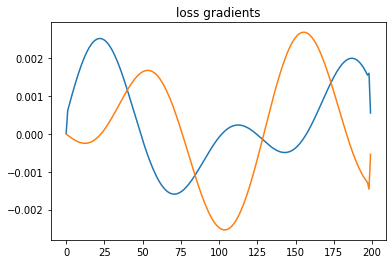

In [10]:
import MT
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(driving_interpolator_r.yOrig)
    tape.watch(driving_interpolator_i.yOrig)
    tape.watch(drv_freq)

    %time res2= ode_s.integrate(tSteps, step_size = (tSteps[1]-tSteps[0])/2) #, grad_pair=grad_pair 
    %time grad_r, grad_i=tape.gradient(tf.reduce_mean(res2[-1][1]), (driving_interpolator_r.yOrig, driving_interpolator_i.yOrig))
grad = grad_r.numpy() + 1j*grad_i.numpy()

title('loss gradients')
plot(grad.real, label='real')
plot(grad.imag, label='imag')
#xlim([25, 30])

Because of the adaptive stepping, gradients can be a little jagged due to some steps sample more than others. Doing a moving average of 2 points gets rid of some of it. Not sure how sustainable this is

(75.0, 125.0)

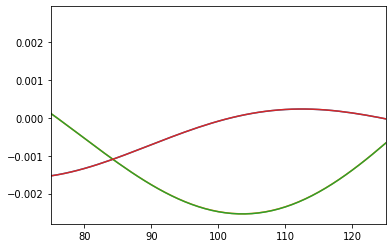

In [11]:
import MT
smth = lambda y: MT.smooth(y,2+1) # This actually should be a moving average of 2 (dont' ask why)
plot(smth(grad.real) )
plot(smth(grad.imag))
plot(grad.imag)
plot(grad.real )
xlim([75,125])


## Optimize:
A simple two level system

In [19]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow_probability as tfp
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import InterpolatorMask2, InterpolatorMask, InterpolatorMaskArgs

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *


#problem definition
K1, K2  = q.basis(2,0), q.basis(2,1), 
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)
H0 = 4*pi*K2*K2.dag()
c_opL = [sqrt(.5)*q.sigmap()]

H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-.001,.001,10)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )


tDrv = np.linspace(0,2.0,100)
tSteps = np.linspace(0,2.0, 100)#tDrv[:-1].copy()

tDrv -= (tDrv[1]-tDrv[0])/2


driving =  np.exp(2j*2*np.pi* tDrv)
driving_interpolator_r = InterpolatorMask2(tDrv, driving.real)
driving_interpolator_i = InterpolatorMask2(tDrv, driving.imag)

def f_r(t):
    #return 5*tf.tanh(driving_interpolator_r(t))*1#tf.cos(-0*2*pi*t)
    return driving_interpolator_r(t)#tf.cos(-0*2*pi*t)


def f_i(t):
    #return 5*tf.tanh(driving_interpolator_i(t))*1#tf.sin(-0*2*pi*t)
    return driving_interpolator_i(t)#tf.sin(-0*2*pi*t)


#ode_s.set_driving({ES_r:driving_interpolator_r, ES_i:driving_interpolator_i})
ode_s.set_driving({ES_r:f_r, ES_i:f_i})

ode_s.setup(bForceStateDimensions=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E_r, E_i], 'state_dep_syms': [Delta]})
state dependent functions should have signature <itertools.chain object at 0x7423cc4786d0>


In [26]:
import MT
from scipy import optimize
from numpy import random
smth = lambda x: 1*x*(1 + 0.000*np.random.normal(x.size))
def stack(cmplx):
    return np.hstack([cmplx.real,cmplx.imag])
def unstack(stacked):
    return stacked[:N] + 1j * stacked[N:]

N = tDrv.size
#drv0 = .01*np.where(tDrv<1, 0, 1.0)*np.exp(2j*2*pi*tDrv) + 0.0*random.normal(size=N) + .1j*random.normal(size=N)#np.ones(tDrv.size)*(.1 + 0j)
#drv0 = 18*np.where(tDrv<1.9, 0, 1.0)*np.exp(0j*2*pi*tDrv) 

@tf.function(experimental_compile=False)
def run(drv_r, drv_i):
    driving_interpolator_r.set_y(drv_r)
    driving_interpolator_i.set_y(drv_i)
    res= ode_s.integrate(tSteps, step_size=(tSteps[1]-tSteps[0])/2) 
    return res

@tf.function(experimental_compile=False)
def just_run(driving):
    drv_r, drv_i = driving[:N], driving[N:]
    return run(drv_r, drv_i)

resL, gradL, drvL = [], [], []

def get_loss(driving):
    drv_r, drv_i = driving[:N], driving[N:]
    driving_interpolator_r.set_y(drv_r)
    driving_interpolator_i.set_y(drv_i)

    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(driving_interpolator_r.yOrig)
        tape.watch(driving_interpolator_i.yOrig)

 
        res= ode_s.integrate(tSteps, step_size=(tSteps[1]-tSteps[0])/8) 

        L = tf.reduce_mean(1-res[-1,1]) # state at the end
       # tf.reduce_mean(1-arr[-1,2]**2)
        grad_r, grad_i=tape.gradient(L, (driving_interpolator_r.yOrig, driving_interpolator_i.yOrig))
    L =L.numpy()
    print("Loss: ", L)
    resL.append(res.numpy().copy())
    gradL.append(grad_r.numpy().copy() + 1j*grad_i.numpy().copy())
    drvL.append(drv_r.copy() + 1j*drv_i.copy())
    return L, np.hstack([smth(grad_r.numpy()), 1*smth(grad_i.numpy()) ])



@tf.function(experimental_compile=False)
def get_loss2(driving):
    drv_r, drv_i = driving[:N], driving[N:]



    
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(driving_interpolator_r.yOrig)
        tape.watch(driving_interpolator_i.yOrig)
        res = run(drv_r, drv_i)
        L = tf.reduce_mean(1-res[-1,1])**2 # state at the end
       # tf.reduce_mean(1-arr[-1,2]**2)
        grad_r, grad_i=tape.gradient(L, (driving_interpolator_r.yOrig, driving_interpolator_i.yOrig))
    return L, grad_r, grad_i
    #L =L.numpy()
    #print("Loss: ", L)
    #resL.append(res)
    #gradL.append(grad_r.numpy() + 1j*grad_i.numpy())
    #drvL.append(drv_r + 1j*drv_i)
    #return L, np.hstack([smth(grad_r.numpy()), 1*smth(grad_i.numpy()) ])
#driving
#get_loss(stack(drv0) )
res=optimize.minimize(get_loss, stack(drv0), method='BFGS',jac=True, options={'maxiter':20}) #jac=True means the second return value from "get_loss" is the gradient

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 4752
Loss:  0.9997562735323134
num function evaluations: 4752
Loss:  0.9997307079079654
num function evaluations: 4752
Loss:  0.9996157059164789
num function evaluations: 4752
Loss:  0.9989519917243171
num function evaluations: 4752
Loss:  0.9930527207040601
num function evaluations: 4752
Loss:  0.9202076980937155
num function evaluations: 4752
Loss:  0.32085761511090827
num function evaluations: 4752
Loss:  0.45816313945068643
num function evaluations: 4752
Loss:  0.7408981256653518
num function evaluations: 4752
Loss:  0.257311021998751
num function evaluations: 4752
Loss:  0.2554943528691501
num function evaluations: 4752
Loss:  0.27883198327579584
num function evaluations: 4752
Loss:  0.2554785914657546
num function evaluations: 4752
Loss:  0.2554467025639816
num function evaluations: 4752
Loss:  0.25531917135129095
num function evaluations: 4752
Loss:  0.25480943808207474
num function evaluations: 4752
Loss:  0.25277685106605247
num function evaluations: 

In [14]:
resL.clear(); gradL.clear(); drvL.clear()

In [16]:
drv_cur = stack(drv0)
#drv_cur = res.x
for k in range(50):
    L, grad = get_loss(drv_cur)
    print(L)
    drv_cur -=5*grad

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1188
Loss:  0.999342785238689
0.999342785238689
num function evaluations: 1188
Loss:  0.9989808649273384
0.9989808649273384
num function evaluations: 1188
Loss:  0.9984196536206659
0.9984196536206659
num function evaluations: 1188
Loss:  0.9975497780977651
0.9975497780977651
num function evaluations: 1188
Loss:  0.9962024943525666
0.9962024943525666
num function evaluations: 1188
Loss:  0.9941184170611479
0.9941184170611479
num function evaluations: 1188
Loss:  0.9909011325528928
0.9909011325528928
num function evaluations: 1188
Loss:  0.9859502945981748
0.9859502945981748
num function evaluations: 1188
Loss:  0.9783696522439739
0.9783696522439739
num function evaluations: 1188
Loss:  0.9668512813365115
0.9668512813365115
num function evaluations: 1188
Loss:  0.9495549312767553
0.9495549312767553
num function evaluations: 1188
Loss:  0.9240422722265904
0.9240422722265904
num function evaluations: 1188
Loss:  0.8874007701151285
0.8874007701151285
num function e

KeyboardInterrupt: 

In [35]:
def get_loss4(driving):
    drv_r, drv_i = driving[:N], driving[N:]
    driving_interpolator_r.set_y(drv_r)
    driving_interpolator_i.set_y(drv_i)
    
    with tf.GradientTape(watch_accessed_variables=True) as outer_tape:
        outer_tape.watch(driving_interpolator_r.yOrig)
        outer_tape.watch(driving_interpolator_i.yOrig)
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(driving_interpolator_r.yOrig)
            tape.watch(driving_interpolator_i.yOrig)


            res= ode_s.integrate(tSteps, step_size=(tSteps[1]-tSteps[0])/1) 

            L = tf.reduce_mean(1-res[-1,1]) # state at the end
           # tf.reduce_mean(1-arr[-1,2]**2)
            grad_r, grad_i=tape.gradient(L, (driving_interpolator_r.yOrig, driving_interpolator_i.yOrig))
        hess_r =outer_tape.gradient(grad_r, (driving_interpolator_r.yOrig))

    L =L.numpy()
    print("Loss: ", L)
    resL.append(res.numpy().copy())
    gradL.append(grad_r.numpy().copy() + 1j*grad_i.numpy().copy())
    drvL.append(drv_r.copy() + 1j*drv_i.copy())
    return L, np.hstack([smth(grad_r.numpy()), 1*smth(grad_i.numpy()) ]), (hess_r, hess_i)
L, grad, hess =get_loss4(res.x)
#res=optimize.minimize(get_loss4, res.x, method='BFGS',jac=True, options={'maxiter':30, 'disp':True, 'gtol':1e-8}) #jac=True means the second return value from "get_loss" is the gradient


num function evaluations: 600


AttributeError: 'NoneType' object has no attribute 'python_grad_func'

In [ ]:
L, grad, hess =get_loss4(res.x)


In [62]:
def get_loss3(drv): 
    L, grad = get_loss(drv)
    return L, 50*grad
res=optimize.minimize(get_loss3, res.x, method='BFGS',jac=True, options={'maxiter':10, 'disp':True, 'gtol':1e-8}) #jac=True means the second return value from "get_loss" is the gradient


num function evaluations: 1188
Loss:  0.016986336432848515
num function evaluations: 1188
Loss:  0.016996903856966172
num function evaluations: 1188
Loss:  0.016988526160144124
num function evaluations: 1188
Loss:  0.016986791494399654
num function evaluations: 1188
Loss:  0.016986431059855978
num function evaluations: 1188
Loss:  0.016986356112404198
num function evaluations: 1188
Loss:  0.016986340525710398
num function evaluations: 1188
Loss:  0.016986337284068332
num function evaluations: 1188
Loss:  0.016986336609883534
num function evaluations: 1188
Loss:  0.016986336469669107
num function evaluations: 1188
Loss:  0.016986336440508377
num function evaluations: 1188
Loss:  0.016986336434442827
num function evaluations: 1188
Loss:  0.016986336433180194
num function evaluations: 1188
Loss:  0.01698633643291917
num function evaluations: 1188
Loss:  0.016986336432863857
num function evaluations: 1188
Loss:  0.01698633643285208
num function evaluations: 1188
Loss:  0.016986336432849424

KeyboardInterrupt: 

In [19]:
res=optimize.minimize(get_loss, res.x, method='Nelder-Mead',jac=True, options={'maxiter':10, 'disp':True}) #jac=True means the second return value from "get_loss" is the gradient


num function evaluations: 1188
Loss:  0.05602596756041502
num function evaluations: 1188
Loss:  0.056026277379317
num function evaluations: 1188
Loss:  0.056028878719486044
num function evaluations: 1188
Loss:  0.056030341004492126
num function evaluations: 1188
Loss:  0.05602844827316358
num function evaluations: 1188
Loss:  0.05602676439877095
num function evaluations: 1188
Loss:  0.05602573143404299
num function evaluations: 1188
Loss:  0.05602549454955136
num function evaluations: 1188
Loss:  0.05602592680464202
num function evaluations: 1188
Loss:  0.05602687433673158
num function evaluations: 1188
Loss:  0.05602824767357255
num function evaluations: 1188
Loss:  0.0560295858839316
num function evaluations: 1188
Loss:  0.056030628697804875
num function evaluations: 1188
Loss:  0.05603108236324322
num function evaluations: 1188
Loss:  0.05603081075584084
num function evaluations: 1188
Loss:  0.05602987676610053
num function evaluations: 1188
Loss:  0.05602851790238832
num function e

KeyboardInterrupt: 

In [24]:
res=optimize.minimize(get_loss, stack(drv0), method='BFGS',jac=True, options={'maxiter':10}) #jac=True means the second return value from "get_loss" is the gradient
for k in range(1):
    res=optimize.minimize(get_loss, res.x, method='newton-CG', jac=True, options={'maxiter':5, 'gtol': 1e-06,})
    res=optimize.minimize(get_loss, res.x, method='BFGS', jac=True, options={'maxiter':3})

num function evaluations: 1188
Loss:  0.9928770258520212
num function evaluations: 1188
Loss:  0.9653940079781732
num function evaluations: 1188
Loss:  0.6993137199175469
num function evaluations: 1188
Loss:  0.666617367969479
num function evaluations: 1188
Loss:  0.2845859333955579
num function evaluations: 1188
Loss:  0.42261255372576684
num function evaluations: 1188
Loss:  0.28224452138924694
num function evaluations: 1188
Loss:  0.2777086635866251
num function evaluations: 1188
Loss:  0.2612288734909608
num function evaluations: 1188
Loss:  0.2250914435617207
num function evaluations: 1188
Loss:  0.16954828977404923
num function evaluations: 1188
Loss:  0.10594462330006549
num function evaluations: 1188
Loss:  0.09536704235427626
num function evaluations: 1188
Loss:  0.09377659337228267
num function evaluations: 1188
Loss:  0.09233531590695163
num function evaluations: 1188
Loss:  0.09052210005947373


<ipython-input-24-8683be0cc56d>:3: OptimizeWarning: Unknown solver options: gtol
  res=optimize.minimize(get_loss, res.x, method='newton-CG', jac=True, options={'maxiter':5, 'gtol': 1e-06,})


num function evaluations: 1188
Loss:  0.09052210005947373
num function evaluations: 1188
Loss:  0.09052210003142189
num function evaluations: 1188
Loss:  0.09051977105356926
num function evaluations: 1188
Loss:  0.09051047047216736
num function evaluations: 1188
Loss:  0.09047351528902119
num function evaluations: 1188
Loss:  0.09040754253342237
num function evaluations: 1188


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Loss:  0.09051977105356926
num function evaluations: 1188
Loss:  0.09051744359182588
num function evaluations: 1188
Loss:  0.0905127933010651
num function evaluations: 1188
Loss:  0.09050351125211942
num function evaluations: 1188
Loss:  0.09048502129792596
num function evaluations: 1188
Loss:  0.09044833807134617
num function evaluations: 1188
Loss:  0.09037615919942532
num function evaluations: 1188
Loss:  0.09023655857920125
num function evaluations: 1188
Loss:  0.08997643968555952


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1188
Loss:  0.08997643966577938
num function evaluations: 1188
Loss:  0.08997643968555952
num function evaluations: 1188
Loss:  0.0899764396755315
num function evaluations: 1188
Loss:  0.08997627377182894
num function evaluations: 1188
Loss:  0.08997561020905392
num function evaluations: 1188
Loss:  0.08997295743242532
num function evaluations: 1188
Loss:  0.08996815528823272
num function evaluations: 1188


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Loss:  0.08997627377182894
num function evaluations: 1188
Loss:  0.08997610786731146
num function evaluations: 1188
Loss:  0.08997577608592462
num function evaluations: 1188
Loss:  0.08997511263373334
num function evaluations: 1188
Loss:  0.08997378617169263
num function evaluations: 1188
Loss:  0.08997113501704261
num function evaluations: 1188
Loss:  0.08996583978594137
num function evaluations: 1188
Loss:  0.08995527764035756
num function evaluations: 1188
Loss:  0.08993426664617314
num function evaluations: 1188
Loss:  0.08989269808957834
num function evaluations: 1188
Loss:  0.08981137664906977
num function evaluations: 1188


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Loss:  0.08981137663139516
num function evaluations: 1188
Loss:  0.08981104135855897
num function evaluations: 1188
Loss:  0.08980970058329482
num function evaluations: 1188
Loss:  0.08980434367094785
num function evaluations: 1188
Loss:  0.08979465950893739


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1188
Loss:  0.08981104135855897
num function evaluations: 1188
Loss:  0.08981070610672758
num function evaluations: 1188
Loss:  0.08981003571909403
num function evaluations: 1188
Loss:  0.08980869540796724
num function evaluations: 1188
Loss:  0.08980601664232724
num function evaluations: 1188
Loss:  0.08980066653807903
num function evaluations: 1188
Loss:  0.08978999604209296
num function evaluations: 1188
Loss:  0.08976877393541813
num function evaluations: 1188
Loss:  0.08972680554496815
num function evaluations: 1188
Loss:  0.08964477430345881
num function evaluations: 1188
Loss:  0.08948835186816877


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1188
Loss:  0.08948835185414916
num function evaluations: 1188
Loss:  0.089488026943092
num function evaluations: 1188
Loss:  0.08948672760137052
num function evaluations: 1188
Loss:  0.08948153597213562
num function evaluations: 1188
Loss:  0.08947214954651808
num function evaluations: 1188


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Loss:  0.089488026943092
num function evaluations: 1188
Loss:  0.08948770205387338
num function evaluations: 1188
Loss:  0.08948705238301248
num function evaluations: 1188
Loss:  0.08948575347159712
num function evaluations: 1188
Loss:  0.08948315737006673
num function evaluations: 1188
Loss:  0.08947797205280236
num function evaluations: 1188
Loss:  0.08946762896614849
num function evaluations: 1188
Loss:  0.08944705302192385
num function evaluations: 1188
Loss:  0.08940634234998876
num function evaluations: 1188
Loss:  0.08932668826850808
num function evaluations: 1188
Loss:  0.089174468240419


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1188
Loss:  0.08917446822909394
num function evaluations: 1188
Loss:  0.08903517953001797
num function evaluations: 1188
Loss:  0.08853708357423906
num function evaluations: 1188
Loss:  0.08853708357423906
num function evaluations: 1188
Loss:  0.08799110718458888
num function evaluations: 1188
Loss:  0.0860610574095634
num function evaluations: 1188
Loss:  0.08177111897664881
num function evaluations: 1188
Loss:  0.07509443751157747


In [7]:
for k in range(10):
    res=optimize.minimize(get_loss, res.x, method='newton-CG', jac=True, options={'maxiter':2, 'gtol': 1e-06,})
    res=optimize.minimize(get_loss, res.x, method='BFGS', jac=True, options={'maxiter':2})
    res=optimize.minimize(get_loss, res.x, method='CG', jac=True, options={'maxiter':2})

<ipython-input-7-2abc3e610481>:2: OptimizeWarning: Unknown solver options: gtol
  res=optimize.minimize(get_loss, res.x, method='newton-CG', jac=True, options={'maxiter':2, 'gtol': 1e-06,})
/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 534
Loss:  0.07853429627958826
num function evaluations: 534
Loss:  0.07853429643358542
num function evaluations: 534
Loss:  0.07853429627958826
num function evaluations: 534
Loss:  0.07853429667969081
num function evaluations: 534
Loss:  0.07853429627958826
num function evaluations: 534
Loss:  0.07853454887800053
num function evaluations: 534
Loss:  0.07853429627958826
num function evaluations: 534
Loss:  0.07856504199723771
num function evaluations: 582
Loss:  0.7622463893447546
num function evaluations: 594
Loss:  0.0849042413786997
num function evaluations: 504
Loss:  0.08271383016032355
num function evaluations: 540
Loss:  0.08503298151870922
num function evaluations: 534
Loss:  0.07853460577940763
num function evaluations: 534
Loss:  0.07853430778285886
num function evaluations: 582


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Loss:  0.7622463893447546
num function evaluations: 582
Loss:  0.11362557517642771
num function evaluations: 600
Loss:  0.07838016978613108
num function evaluations: 600


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Loss:  0.07838016974638504
num function evaluations: 618
Loss:  0.08253854994769876
num function evaluations: 600
Loss:  0.07837696590964144
num function evaluations: 558
Loss:  0.08023894514698998
num function evaluations: 600
Loss:  0.07837398491658157
num function evaluations: 594
Loss:  0.08035917524995508
num function evaluations: 600
Loss:  0.07837276836434329
num function evaluations: 624
Loss:  0.08016653428386314
num function evaluations: 600
Loss:  0.07837218613071142
num function evaluations: 594
Loss:  0.08025326448386219
num function evaluations: 600
Loss:  0.07837194459399377
num function evaluations: 600
Loss:  0.0804348663282379
num function evaluations: 600
Loss:  0.07837184886329401
num function evaluations: 684
Loss:  0.08027133845152583
num function evaluations: 600
Loss:  0.07837180367212068
num function evaluations: 600
Loss:  0.07835762468685117
num function evaluations: 678
Loss:  0.08023364736499132
num function evaluations: 600
Loss:  0.07835762235248055
num f

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Loss:  0.08253854994769876
num function evaluations: 606
Loss:  0.07861435828791362
num function evaluations: 582
Loss:  0.07873541008567919
num function evaluations: 612
Loss:  0.08146271464501084
num function evaluations: 600
Loss:  0.07836431818478554
num function evaluations: 600
Loss:  0.07835632498424124
num function evaluations: 678
Loss:  0.08023777240987365
num function evaluations: 594
Loss:  0.0807978364428533
num function evaluations: 594
Loss:  0.08077292660510653
num function evaluations: 594
Loss:  0.08076072734185043
num function evaluations: 594
Loss:  0.08075469229814622
num function evaluations: 600
Loss:  0.0783561997320459
num function evaluations: 600


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Loss:  0.07838016978613108
num function evaluations: 522
Loss:  0.08331552794984488
num function evaluations: 522
Loss:  0.0818128583457426
num function evaluations: 600
Loss:  0.07837806848535181
num function evaluations: 570
Loss:  0.0808736403486281
num function evaluations: 600
Loss:  0.07837682473312851
num function evaluations: 594
Loss:  0.0791507593161341


KeyboardInterrupt: 

In [63]:
%time L, grad_r, grad_i=get_loss2(stack(10*drv0))
print(L)
%time L, grad_r, grad_i=get_loss2(stack(drv0))
%time L, grad=get_loss(stack(drv0))



print(L)

CPU times: user 755 ms, sys: 51 ms, total: 806 ms
Wall time: 594 ms
tf.Tensor(0.7127783851338432, shape=(), dtype=float64)
CPU times: user 848 ms, sys: 40 ms, total: 888 ms
Wall time: 813 ms
num function evaluations: 1188
Loss:  0.9918063028895663
CPU times: user 744 ms, sys: 37 ms, total: 781 ms
Wall time: 514 ms
0.9918063028895663


In [ ]:
drv0 =np.hstack([smth(grad_r.numpy()), 1*smth(grad_i.numpy()) ])

In [121]:
#continue from above
#res=optimize.minimize(get_loss, res.x, method='newton-CG', jac=True, options={'maxiter':5, 'gtol': 1e-06,})
res=optimize.minimize(get_loss, res.x, method='newton-CG', jac=True, options={'maxiter':10, 'gtol': 1e-08,})

<ipython-input-121-c0c475586e07>:3: OptimizeWarning: Unknown solver options: gtol
  res=optimize.minimize(get_loss, res.x, method='newton-CG', jac=True, options={'maxiter':10, 'gtol': 1e-08,})
/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1188
Loss:  0.058206565588548864
num function evaluations: 1188
Loss:  0.058206565588027226
num function evaluations: 1188
Loss:  0.058206565588548864
num function evaluations: 1188
Loss:  0.058206565588406145
num function evaluations: 1188
Loss:  0.058206565588548864
num function evaluations: 1188
Loss:  0.05820656556536765
num function evaluations: 1188
Loss:  0.058206565588548864
num function evaluations: 1188
Loss:  0.058206565588539774
num function evaluations: 1188
Loss:  0.058206565588548864
num function evaluations: 1188
Loss:  0.0582065655860861
num function evaluations: 1188
Loss:  0.058206565588548864
num function evaluations: 1188
Loss:  0.05820656558842441
num function evaluations: 1188
Loss:  0.058206565588548864
num function evaluations: 1188
Loss:  0.05820656558585231
num function evaluations: 1188
Loss:  0.058206565588548864
num function evaluations: 1188
Loss:  0.05820656558850331
num function evaluations: 1188
Loss:  0.058206565588548864
num

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 1188
Loss:  0.05781819302461862
num function evaluations: 1188
Loss:  0.05781580750115563
num function evaluations: 1188
Loss:  0.05782515817795277
num function evaluations: 1188
Loss:  0.057817881328663626
num function evaluations: 1188
Loss:  0.05781613436529056
num function evaluations: 1188
Loss:  0.05781585528509753
num function evaluations: 1188
Loss:  0.05781581054038072
num function evaluations: 1188
Loss:  0.0578158055078596
num function evaluations: 1188
Loss:  0.05781580742620607
num function evaluations: 1188
Loss:  0.057815805926119325
num function evaluations: 1188
Loss:  0.057815805630580454
num function evaluations: 1188
Loss:  0.057815805549345435
num function evaluations: 1188
Loss:  0.05781580552368215
num function evaluations: 1188
Loss:  0.057815805514315255


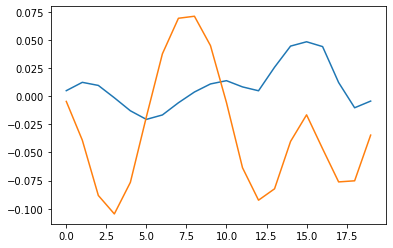

In [14]:
jac = unstack(res.jac)
plot(jac.real)
plot(jac.imag)

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


num function evaluations: 600


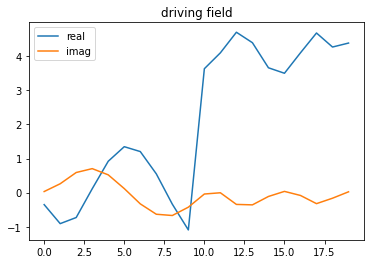

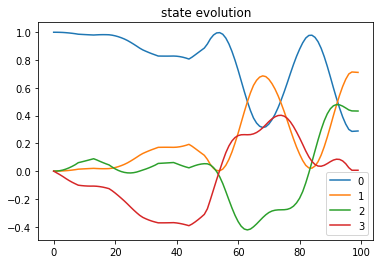

In [15]:
drv = unstack(res.x)
plot(drv.real, label='real')
plot(drv.imag, label='imag')
title('driving field')
legend()

states = just_run(drv)
figure()
plot(states[:,:,50])
title('state evolution')
legend(np.arange(4))

In [ ]:
for res, grad, drv in list(zip(resL, gradL, drvL)):
    figure

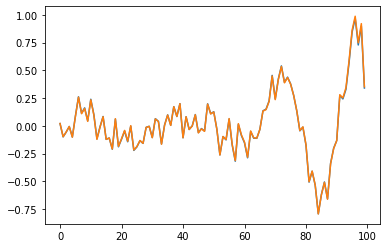

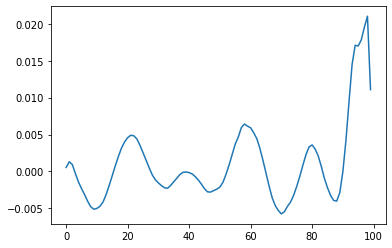

In [111]:
k = 18
plot(drvL[-k-1].real)
plot(drvL[-k].real)
figure()
plot(drvL[-k].real-drvL[-k-1].real)

In [97]:
np.array(drvL).shape

(308, 100)

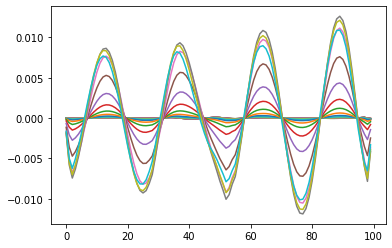

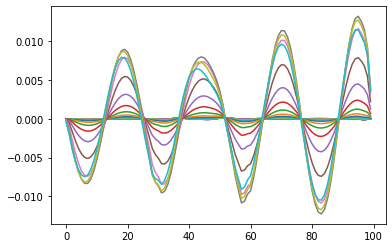

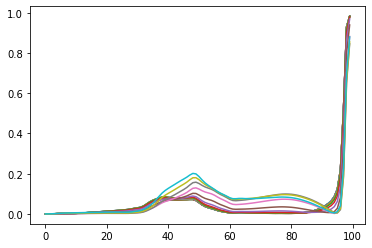

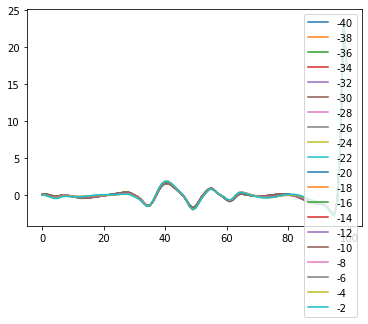

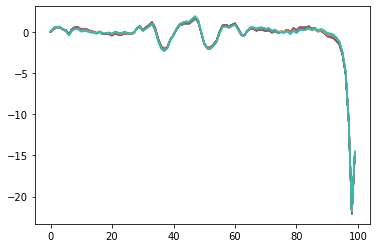

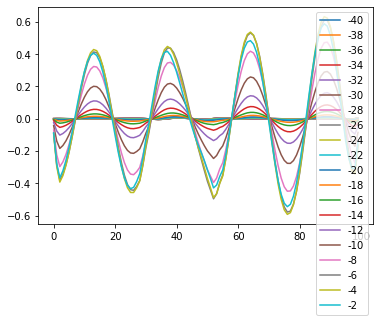

In [66]:
ax1 = subplot(111)
figure()
ax2 = subplot(111)
figure()
ax3 = subplot(111)
figure()
ax4 = subplot(111)
figure()
ax5 = subplot(111)
figure()
ax6 = subplot(111)
#for states, grad,drv in list(zip(resL, gradL, drvL))[-10::1]:
for k in range(-40,-1,2):

    ax1.plot(gradL[k].real, label='real')
    ax2.plot(gradL[k].imag, label='imag')
    ax3.plot(resL[k][:,1].mean(axis=-1).real)
    ax4.plot(drvL[k].real, label=k)
    ax5.plot(drvL[k].imag)
    ax6.plot(drvL[k].real- drvL[k-1].real, label=k)
    
#ax4.set_ylim([-0.5, 0.5])
#ax5.set_ylim([-0.5, 0.5])

   
ax4.legend()
ax6.legend()

In [22]:
res

<tf.Tensor: shape=(100, 4, 100), dtype=float64, numpy=
array([[[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.99760809,  0.99760809,  0.99760809, ...,  0.99760807,
          0.99760807,  0.99760807],
        [ 0.00239191,  0.00239191,  0.00239191, ...,  0.00239193,
          0.00239193,  0.00239193],
        [ 0.00309129,  0.00309139,  0.00309149, ...,  0.00310096,
          0.00310106,  0.00310116],
        [-0.04875074, -0.04875073, -0.04875073, ..., -0.04875033,
         -0.04875032, -0.04875032]],

       [[ 0.99050342,  0.99050341,  0.99050341, ...,  0.9905031 ,
          0.99050309,  0.99050309],
        [ 0.00949658,  

In [88]:
drv0 = 18*np.where(tDrv<1.9, 0, 1.0)*np.exp(0j*2*pi*tDrv) 

def run(drv_cmplx):
    return just_run (np.hstack([drv_cmplx.real, drv_cmplx.imag] )).numpy()
res=run(drv0)

num function evaluations: 1188


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


0.05950059116705507


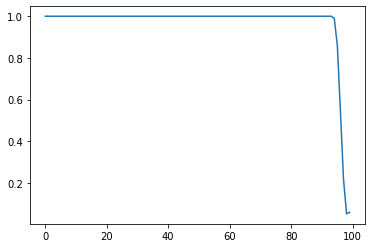

In [89]:
evo =res[:,0].mean(axis=-1)
plot(evo)
print(evo[-1])